# NMT Implementation in Python using Keras

In [1]:
# https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [7]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)


In [13]:
#deu_eng = deu_eng[:50000,:]
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['The man died of cancer.', 'Der Mann starb an Krebs.'],
       ['The man lay motionless.', 'Der Mann lag bewegungslos da.'],
       ['The man must be insane.', 'Der Mann muss geistesgestört sein.']],
      dtype='<U537')

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Wenn jemand Fremdes dir sagt dass du dich wie ein Muttersprachler anhörst bedeutet das wahrscheinlich Er hat etwas an deinem Sprechen bemerkt dass dich als NichtMuttersprachler verraten hat Mit anderen Worten Du hörst dich nicht wirklich wie ein Muttersprachler an'],
       ['It may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort However if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'Es ist wohl unmöglich einen vollkommen fehlerfreien Korpus zu erre

In [9]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker',
        'wenn jemand fremdes dir sagt dass du dich wie ein muttersprachler anhörst bedeutet das wahrscheinlich er hat etwas an deinem sprechen bemerkt dass dich als nichtmuttersprachler verraten hat mit anderen worten du hörst dich nicht wirklich wie ein muttersprachler an'],
       ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'es ist wohl unmöglich einen vollkommen fehlerfreien korpus zu erre

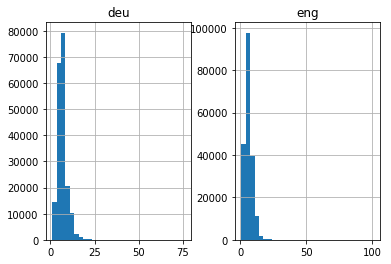

In [10]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [11]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)


English Vocabulary Size: 16172


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 35021


In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq


In [15]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [17]:
# build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length= in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences = True))
      model.add(Dense(out_vocab, activation = 'softmax'))
      return model

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

W0828 08:50:19.566350 123248 deprecation_wrapper.py:119] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 08:50:19.581350 123248 deprecation_wrapper.py:119] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 08:50:19.585350 123248 deprecation_wrapper.py:119] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 08:50:20.042350 123248 deprecation.py:323] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.p

In [19]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

W0828 08:50:23.763350 123248 deprecation_wrapper.py:119] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 08:50:23.770350 123248 deprecation_wrapper.py:119] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [20]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

W0828 08:50:27.182350 123248 deprecation_wrapper.py:119] From C:\Users\M316375\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 125341 samples, validate on 31336 samples
Epoch 1/30
125341/125341 [==============================] - 877s 7ms/step - loss: 4.9479 - val_loss: 4.7883

Epoch 00001: val_loss improved from inf to 4.78832, saving model to model.h1.24_jan_19
Epoch 2/30
125341/125341 [==============================] - 862s 7ms/step - loss: 4.3793 - val_loss: 4.2021

Epoch 00002: val_loss improved from 4.78832 to 4.20209, saving model to model.h1.24_jan_19
Epoch 3/30
125341/125341 [==============================] - 850s 7ms/step - loss: 3.9426 - val_loss: 3.7887

Epoch 00003: val_loss improved from 4.20209 to 3.78867, saving model to model.h1.24_jan_19
Epoch 4/30
125341/125341 [==============================] - 861s 7ms/step - loss: 3.5390 - val_loss: 3.4422

Epoch 00004: val_loss improved from 3.78867 to 3.44222, saving model to model.h1.24_jan_19
Epoch 5/30
125341/125341 [==============================] - 863s 7ms/step - loss: 3.1831 - val_loss: 3.1651

Epoch 00005: val_loss improved from 3.44222 

KeyboardInterrupt: 

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

NameError: name 'history' is not defined

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [30]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [31]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [32]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [33]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [34]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
7860,the barns on fire,the gate closed
7409,do you want me to wait,do you want me to wait
377,be polite to everyone,be polite
3521,the story was amusing,the story was true
4888,he continued singing,he went singing
6918,tom cant sing,tom cant sing
6325,tom has a plan,tom has a
7654,were brothers,were are brothers
8234,everybody likes you,everybody likes you
4347,ill take you with me,ill taking you
